<a href="https://colab.research.google.com/github/cataluna84/MixtureDensityNetworks/blob/master/MDN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Define the MDN

The following notebook is intended to supply all the code for the corresponding blogpost on Medium [link](http://www.google.com). Please feel free to contact the author directly via [mail](mailto:borchers@bwl.uni-mannheim.de). 

Licensed under GPLv3

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


![Mixture Density Network Illustration](https://cdn-images-1.medium.com/max/1000/1*6-QRiJVy5KYPqt40dQFIGw.png)

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
import tensorflow as tf

tf.enable_eager_execution()
tf.random.set_random_seed(42)
np.random.seed(42)

import tensorflow.keras as K

from tensorflow_probability import distributions as tfd

from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 12})


import warnings
warnings.filterwarnings("always")

def remove_ax_window(ax):
    """
        Remove all axes and tick params in pyplot.
        Input: ax object.
    """
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)  
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
dpi = 140
x_size = 8
y_size = 4
alt_font_size = 14

save_figure = False
use_tb = False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
class MDN(tf.keras.Model):

    def __init__(self, neurons=100, components = 2):
        super(MDN, self).__init__(name="MDN")
        self.neurons = neurons
        self.components = components
        
        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")
        
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, name="mus")
        self.sigmas = Dense(components, activation="nnelu", name="sigmas")
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v, mu_v, sigma_v])
    
class DNN(tf.keras.Model):
    def __init__(self, neurons=100):
        super(DNN, self).__init__(name="DNN")
        self.neurons = neurons
        
        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")
        self.out = Dense(1, activation="linear", name="out")
        
    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        return self.out(x)

In [4]:
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1)*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha, mu, sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    
    log_likelihood = gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y
    
    return -tf.reduce_mean(log_likelihood, axis=-1)

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

In [5]:
no_parameters = 3
components = 1
neurons = 200

opt = tf.train.AdamOptimizer(1e-3)

mon = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [6]:
mdn = MDN(neurons=neurons, components=components)
mdn.compile(loss=gnll_loss, optimizer=opt)

In [7]:
dnn = DNN(neurons=neurons)
dnn.compile(loss="mse", optimizer=opt)

# 2) Set up the Linear Example

In [8]:
samples = int(1e5)

x_data = np.random.sample(samples)[:, np.newaxis].astype(np.float32)
y_data = np.add(5*x_data, np.multiply((x_data)**2, np.random.standard_normal(x_data.shape)))

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.5, random_state=42)

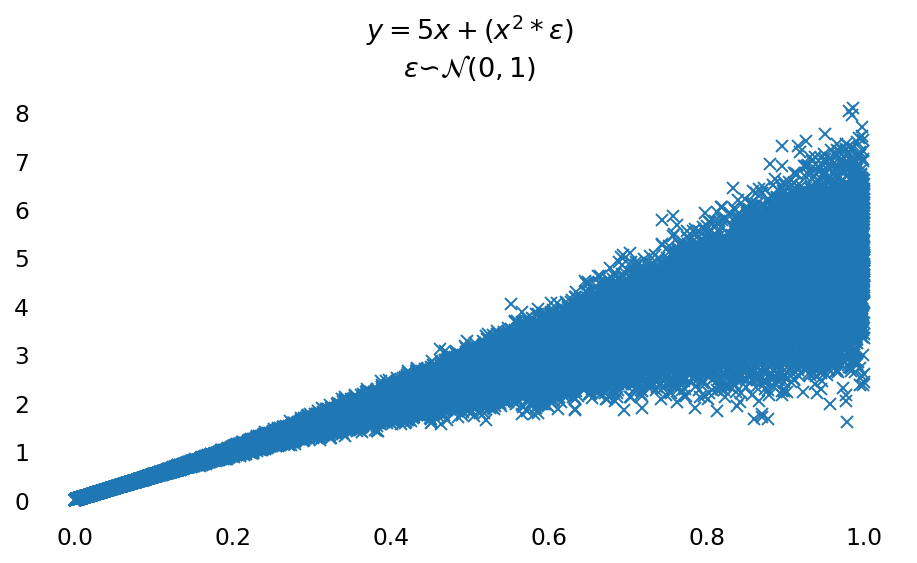

In [9]:
fig = plt.figure(figsize=(x_size,y_size), dpi=dpi)
ax = plt.gca()

ax.set_title(r"$y = 5x + (x^2 * \epsilon)$"+"\n"+r"$\epsilon \backsim \mathcal{N}(0,1)$", fontsize=alt_font_size)
ax.plot(x_train,y_train, "x",alpha=1., color=sns.color_palette()[0])

remove_ax_window(ax)
plt.show()

In [10]:
%%time
s = np.linspace(0.,1.,int(1e3))[:, np.newaxis].astype(np.float32)

mdn.fit(x=x_train, y=y_train,epochs=200, validation_data=(x_test, y_test), callbacks=[mon], batch_size=128, verbose=0)
y_pred = mdn.predict(s)
alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
CPU times: user 29.5 s, sys: 2.24 s, total: 31.7 s
Wall time: 29.3 s


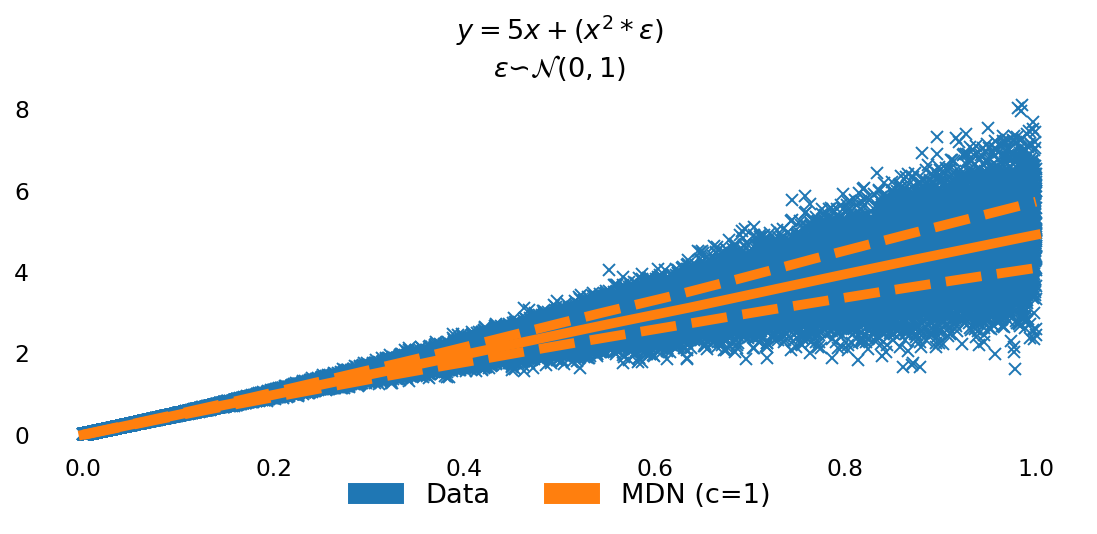

In [11]:
fig = plt.figure(figsize=(x_size,y_size), dpi=dpi)
ax = plt.gca()

ax.set_title(r"$y = 5x + (x^2 * \epsilon)$"+"\n"+r"$\epsilon \backsim \mathcal{N}(0,1)$", fontsize=alt_font_size)
ax.plot(x_train,y_train, "x",alpha=1, color=sns.color_palette()[0])

plt.plot(s,mu_pred+sigma_pred, color=sns.color_palette()[1],linewidth=5, linestyle='--', markersize=3)
plt.plot(s,mu_pred-sigma_pred, color=sns.color_palette()[1],linewidth=5, linestyle='--', markersize=3)
plt.plot(s,mu_pred, color=sns.color_palette()[1],linewidth=5, linestyle='-', markersize=3)

remove_ax_window(ax)

data_leg = mpatches.Patch(color=sns.color_palette()[0])
data_mdn = mpatches.Patch(color=sns.color_palette()[1])

ax.legend(handles = [data_leg, data_mdn],
          labels = ["Data", "MDN (c=1)"],
          loc=9, borderaxespad=0.1, framealpha=1.0, fancybox=True, 
          bbox_to_anchor=(0.5, -0.05), ncol=2, shadow=True, frameon=False,
          fontsize=alt_font_size)

plt.tight_layout()

if save_figure:
    plt.savefig("graphics/mdn_linear_prediction.png", format='png',dpi=dpi, bbox_inches='tight')
    
plt.show()

# 3) Compute NLL Values for Linear Example

In [12]:
def gnll_eval(y, alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)

def eval_null_model(y_test):
    mu_pred = np.full_like(y_test, np.mean(y_test), dtype=np.float32)
    alpha_pred = np.ones_like(mu_pred, dtype=np.float32)
    sigma_pred = np.full_like(mu_pred, np.std(y_pred), dtype=np.float32)

    print("NULL-MSE: {:1.3f}".format(tf.losses.mean_squared_error(np.full_like(y_test, np.mean(y_test), dtype=np.float32), y_test).numpy()))
    print("NULL-NLL: {:1.3f}\n".format(gnll_eval(y_test.astype(np.float32), alpha_pred, mu_pred, sigma_pred).numpy()[0]))
    
def eval_linear_model(x_test, y_test, linear_model):
    mu_pred = linear_model.predict(x_test).astype(np.float32)
    alpha_pred = np.ones_like(mu_pred, dtype=np.float32)
    sigma_pred = np.full_like(mu_pred, np.std(y_pred), dtype=np.float32)

    print("LIN-MSE: {:1.3f}".format(tf.losses.mean_squared_error(mu_pred, y_test).numpy()))
    print("LIN-NLL: {:1.3f}\n".format(gnll_eval(y_test.astype(np.float32), alpha_pred, mu_pred, sigma_pred).numpy()[0]))
    
def eval_dnn_model(x_test, y_test, dnn_model):
    mu_pred = dnn_model.predict(x_test).astype(np.float32)
    alpha_pred = np.ones_like(mu_pred)
    sigma_pred = np.full_like(mu_pred, np.std(y_pred))

    print("DNN-MSE: {:1.3f}".format(tf.losses.mean_squared_error(mu_pred, y_test).numpy()))
    print("DNN-NLL: {:1.3f}\n".format(gnll_eval(y_test.astype(np.float32), alpha_pred, mu_pred, sigma_pred).numpy()[0]))
    
def eval_mdn_model(x_test, y_test, mdn_model):
    y_pred = mdn_model.predict(x_test)
    alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)

    print("MDN-MSE: {:1.3f}".format(tf.losses.mean_squared_error(np.multiply(alpha_pred, mu_pred).sum(axis=-1)[:, np.newaxis], y_test).numpy()))
    print("MDN-NLL: {:1.3f}\n".format(gnll_eval(y_test.astype(np.float32), alpha_pred, mu_pred, sigma_pred).numpy()[0]))

In [13]:
%%time
dnn.fit(x=x_train, y=y_train,epochs=200, validation_data=(x_test, y_test), callbacks=[mon], batch_size=128, verbose=0)
lr = LinearRegression()
lr.fit(x_train, y_train)

CPU times: user 21.8 s, sys: 1.64 s, total: 23.4 s
Wall time: 18 s


In [14]:
eval_null_model(y_test)
eval_linear_model(x_test, y_test, lr)
eval_dnn_model(x_test, y_test, dnn)
eval_mdn_model(x_test, y_test, mdn)

NULL-MSE: 2.280
NULL-NLL: 1.882

LIN-MSE: 0.200
LIN-NLL: 1.187

DNN-MSE: 0.201
DNN-NLL: 1.187

MDN-MSE: 0.202
MDN-NLL: -0.325



# 4) Set up the Non-Linear Example

In [15]:
x_data = np.float32(np.random.uniform(-10, 10, (1, samples)))
r_data = np.array([np.random.normal(scale=np.abs(i)) for i in x_data])
y_data = np.float32(np.square(x_data)+r_data*2.0)

x_data2 = np.float32(np.random.uniform(-10, 10, (1, samples)))
r_data2 = np.array([np.random.normal(scale=np.abs(i)) for i in x_data2])
y_data2 = np.float32(-np.square(x_data2)+r_data2*2.0)

x_data = np.concatenate((x_data,x_data2),axis=1).T
y_data = np.concatenate((y_data,y_data2),axis=1).T

min_max_scaler = MinMaxScaler()
y_data = min_max_scaler.fit_transform(y_data)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.5, random_state=42, shuffle=True)

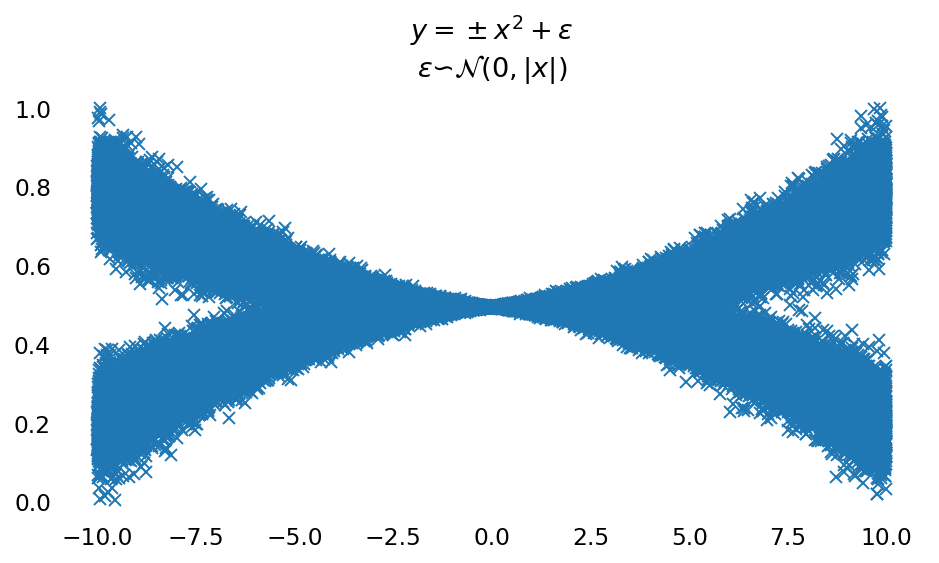

In [16]:
fig = plt.figure(figsize=(x_size,y_size), dpi=dpi)
ax = plt.gca()

ax.set_title(r"$y = \pm x^2 + \epsilon$"+"\n"+r"$\epsilon\backsim\mathcal{N}(0,|x|)$", fontsize=alt_font_size)
ax.plot(x_train,y_train, "x",alpha=1., color=sns.color_palette()[0])

remove_ax_window(ax)
plt.show()

In [17]:
no_parameters = 3
components = 2
neurons = 200

In [18]:
mdn_2 = MDN(neurons=neurons, components=components)
mdn_2.compile(loss=gnll_loss, optimizer=opt)

In [19]:
dnn_2 = DNN(neurons=neurons)
dnn_2.compile(loss="mse", optimizer=opt)

In [20]:
%%time
s = np.linspace(-10,10,int(1e3))[:, np.newaxis].astype(np.float32)

mdn_2.fit(x=x_train, y=y_train,epochs=200, validation_data=(x_test, y_test), callbacks=[mon], batch_size=128, verbose=0)
y_pred = mdn_2.predict(s)
alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)

CPU times: user 44.3 s, sys: 3.66 s, total: 48 s
Wall time: 38.8 s


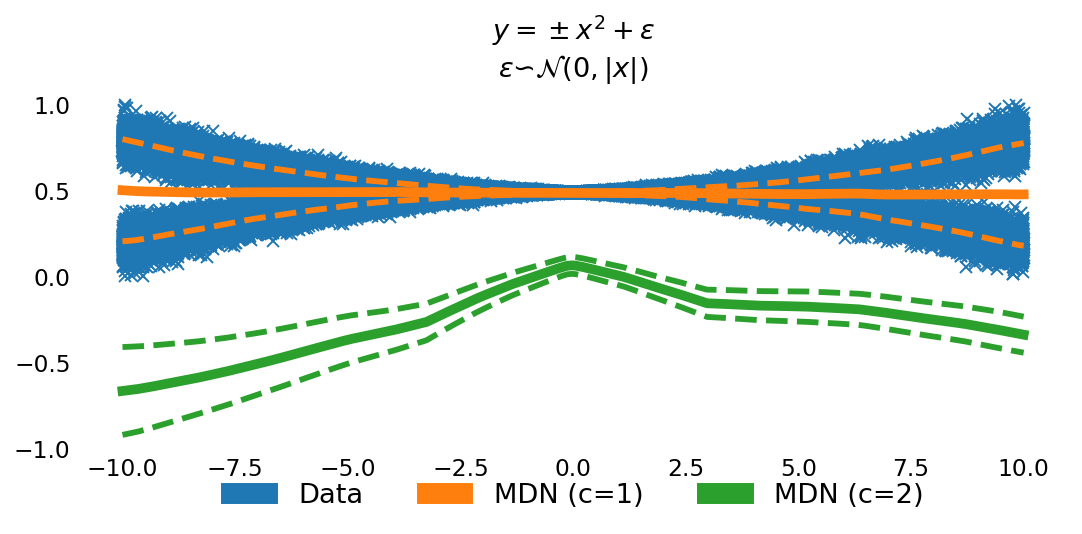

CPU times: user 786 ms, sys: 88 ms, total: 874 ms
Wall time: 783 ms


In [21]:
%%time

fig = plt.figure(figsize=(x_size,y_size), dpi=dpi)
ax = plt.gca()

ax.set_title(r"$y = \pm x^2 + \epsilon$"+"\n"+r"$\epsilon\backsim\mathcal{N}(0,|x|)$", fontsize=alt_font_size)
ax.plot(x_train,y_train, "x",alpha=1, color=sns.color_palette()[0])

for mx in range(components):
    plt.plot(s,mu_pred[:,mx], color=sns.color_palette()[1+mx], linewidth=5, linestyle='-', markersize=3)
    plt.plot(s,mu_pred[:,mx]-sigma_pred[:,mx], color=sns.color_palette()[1+mx],linewidth=3, linestyle='--', markersize=3)
    plt.plot(s,mu_pred[:,mx]+sigma_pred[:,mx], color=sns.color_palette()[1+mx],linewidth=3, linestyle='--', markersize=3)
    
remove_ax_window(ax)

data_leg = mpatches.Patch(color=sns.color_palette()[0])
data_mdn1 = mpatches.Patch(color=sns.color_palette()[1])
data_mdn2 = mpatches.Patch(color=sns.color_palette()[2])

ax.legend(handles = [data_leg, data_mdn1, data_mdn2],
          labels = ["Data", "MDN (c=1)", "MDN (c=2)"],
          loc=9, borderaxespad=0.1, framealpha=1.0, fancybox=True, 
          bbox_to_anchor=(0.5, -0.05), ncol=6, shadow=True, frameon=False,
          fontsize=alt_font_size)

plt.tight_layout()

if save_figure:
    plt.savefig("graphics/mdn_nonlinear_prediction.png", format='png',dpi=dpi, bbox_inches='tight')

plt.show()

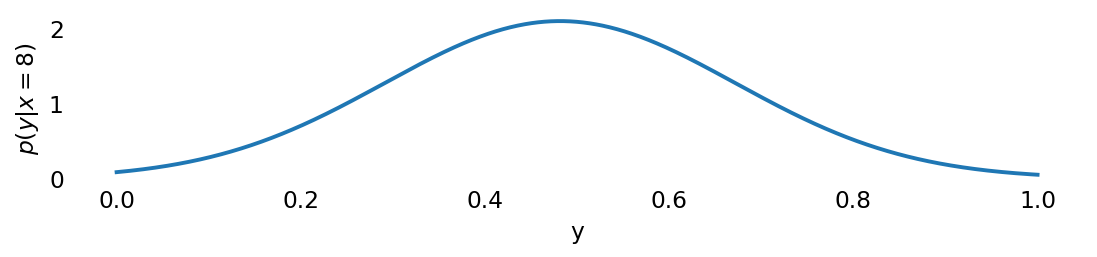

In [22]:
alpha, mu, sigma = slice_parameter_vectors(mdn_2.predict([8.]))

gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))

x = np.linspace(0,1,int(1e3))
pyx = gm.prob(x)

fig = plt.figure(figsize=(x_size,int(y_size/2)), dpi=dpi)
ax = plt.gca()

ax.plot(x,pyx,alpha=1, color=sns.color_palette()[0], linewidth=2)

ax.set_xlabel(r"y")
ax.set_ylabel(r"$p(y|x=8)$")

remove_ax_window(ax)

plt.tight_layout()

if save_figure:
    plt.savefig("graphics/mdn_x8_density.png", format='png',dpi=dpi, bbox_inches='tight')

plt.show()

# 5) Compute NLL Values for Non-Linear Example

In [23]:
%%time
dnn_2.fit(x=x_train, y=y_train,epochs=200, validation_data=(x_test, y_test), callbacks=[mon], batch_size=128, verbose=0)
lr_2 = LinearRegression()
lr_2.fit(x_train, y_train)

CPU times: user 1min 16s, sys: 6.16 s, total: 1min 23s
Wall time: 1min 4s


In [24]:
eval_null_model(y_test)
eval_linear_model(x_test, y_test, lr_2)
eval_dnn_model(x_test, y_test, dnn_2)
eval_mdn_model(x_test, y_test, mdn_2)

NULL-MSE: 0.019
NULL-NLL: 0.090

LIN-MSE: 0.019
LIN-NLL: 0.090

DNN-MSE: 0.019
DNN-NLL: 0.090

MDN-MSE: 0.019
MDN-NLL: -1.414



# 6) Boston Housing

In [25]:
boston = load_boston()
x_data = boston.data
y_data = np.log(boston.target)[:, np.newaxis].astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42, shuffle=True)

min_max_scaler = MinMaxScaler()

x_train = min_max_scaler.fit_transform(x_train) 
x_test = min_max_scaler.transform(x_test) 

In [26]:
no_parameters = 3
components = 4
neurons = 200

In [27]:
mdn_3 = MDN(neurons=neurons, components=components)
mdn_3.compile(loss=gnll_loss, optimizer=opt)

dnn_3 = DNN(neurons=neurons)
dnn_3.compile(loss="mse", optimizer=opt)

In [28]:
%%time
mdn_3.fit(x=x_train, y=y_train,epochs=200, validation_data=(x_test, y_test), callbacks=[mon], batch_size=128, verbose=0)

CPU times: user 1.65 s, sys: 59.3 ms, total: 1.71 s
Wall time: 1.62 s


In [29]:
%%time
dnn_3.fit(x=x_train, y=y_train,epochs=200, validation_data=(x_test, y_test), callbacks=[mon], batch_size=128, verbose=0)
lr_3 = LinearRegression()
lr_3.fit(x_train, y_train)

CPU times: user 1.9 s, sys: 134 ms, total: 2.04 s
Wall time: 1.73 s


In [30]:
eval_null_model(y_test)
eval_linear_model(x_test, y_test, lr_3)
eval_dnn_model(x_test, y_test, dnn_3)
eval_mdn_model(x_test, y_test, mdn_3)

NULL-MSE: 0.154
NULL-NLL: 0.486

LIN-MSE: 0.037
LIN-NLL: 0.142

DNN-MSE: 0.036
DNN-NLL: 0.138

MDN-MSE: 0.041
MDN-NLL: -0.516



# 7) Plot Example for Boston Housing Data

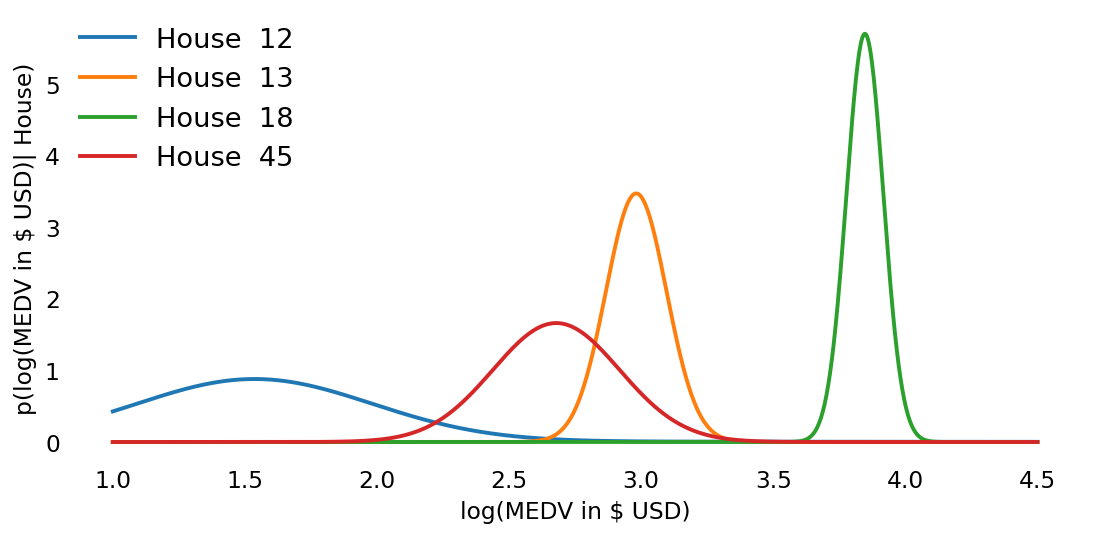

In [31]:
def plot_house(ax, index, col_index):
    alpha, mu, sigma = slice_parameter_vectors(mdn_3.predict([x_test[index].reshape(1,-1)]))

    gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu,       
                scale=sigma))
    pyx = gm.prob(x)
    
    ax.plot(x,pyx,alpha=1, color=sns.color_palette()[col_index], linewidth=2, label="House {:3d}".format(index))
    
    
x = np.linspace(1,4.5,int(1e3))

fig = plt.figure(figsize=(x_size,y_size), dpi=dpi)
ax = plt.gca()

plot_house(ax, 12, 0)
plot_house(ax, 13, 1)
plot_house(ax, 18, 2)
plot_house(ax, 45, 3)

ax.set_xlabel("log(MEDV in $ USD)")
ax.set_ylabel("p(log(MEDV in $ USD)| House)")

remove_ax_window(ax)

ax.legend(loc=0, borderaxespad=0.1, framealpha=1.0, fancybox=True, ncol=1, shadow=True, frameon=False, fontsize=alt_font_size)

plt.tight_layout()

if save_figure:
    plt.savefig("graphics/mdn_boston_density.png", format='png',dpi=dpi, bbox_inches='tight')
    
plt.show()